In [3]:
import json
import csv
import ast
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [1]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [9]:
import string
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shell_basher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/shell_basher/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/shell_basher/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/shell_basher/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [13]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [34]:
reviews_df = pd.read_csv("./processed.csv", keep_default_na=False)
# print(reviews_df['review'])

t to share! The February 2015 Boxycharm 
theme is Kisses from BOXYCHARM and each subscriber
15 box have been released! The February 
theme is PLAY. Click here to visit Loot Crate. Use
t really used the romance and chocolate 
theme without being trite. I think there’s also so
ou weren’t a tea drinker, and it was on-
theme and witty too.
Visit Little Lace Box to find
ndies brought all sorts of fun romantic-
themed underwear! Splendies is a cute & fun undies
: Discovery Box – you’ll find three eco-
themed crafts connected by a monthly theme using a
from My Pretend Place – a new quarterly 
themed pretend play and dress up subscription box 
st Have Box
The Description: Seasonally 
themed must-haves selected by the POPSUGAR editors

theme was A Fresh Start – a kickoff so clean the p
ou can skip a box if you don’t like the 
theme! These are a little pricey even on a 6 month
super antsy about it.

Love with Food‘s 
theme for January was “Live. Laugh. Restore.” and 
loving our Kidstir creations

theme for the August 2016 Box! The theme will be S
ood spoilers for July have arrived! The 
theme this month is Love is Adventure.

Tomato Bas
that any woman would love. You’ll get a 
themed box every month, which includes beauty and 
the items included in the box. The June 
theme is Eco-Friendly.
Booklet
The cause for June 
er 2016 Happy Rebel Box! The summer box 
theme is Poolside Summer!
Every book includes:


I
t card with the quote of the month. The 
theme for this box is Once Upon a Time!

The quote

theme was Midsummer Light. This collection is most
che, unique fragrances curated around a 
theme. Purchase a full bottle that month and credi
was excited to see this and to know the 
theme and a couple of the main items.  A great add
ons!

My BB Bag unpacked.  This month’s 
theme is Festival Friendly Finds.  If only I had t
ded great, age-appropriate messages and 
themes. This was a real win for us. We can’t wait 
ifestyle items a month curated around a 
theme and packaged in a cute

In [35]:
# print(reviews_df['review'])
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

In [43]:
# print(reviews_df["review_clean"])
sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review_clean"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

In [16]:
# Adding number of words and characters as a feature to our dataframe
reviews_df["nb_chars"] = reviews_df["review_clean"].apply(lambda x: len(x))
reviews_df["nb_words"] = reviews_df["review_clean"].apply(lambda x: len(x.split(" ")))

In [18]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [20]:
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

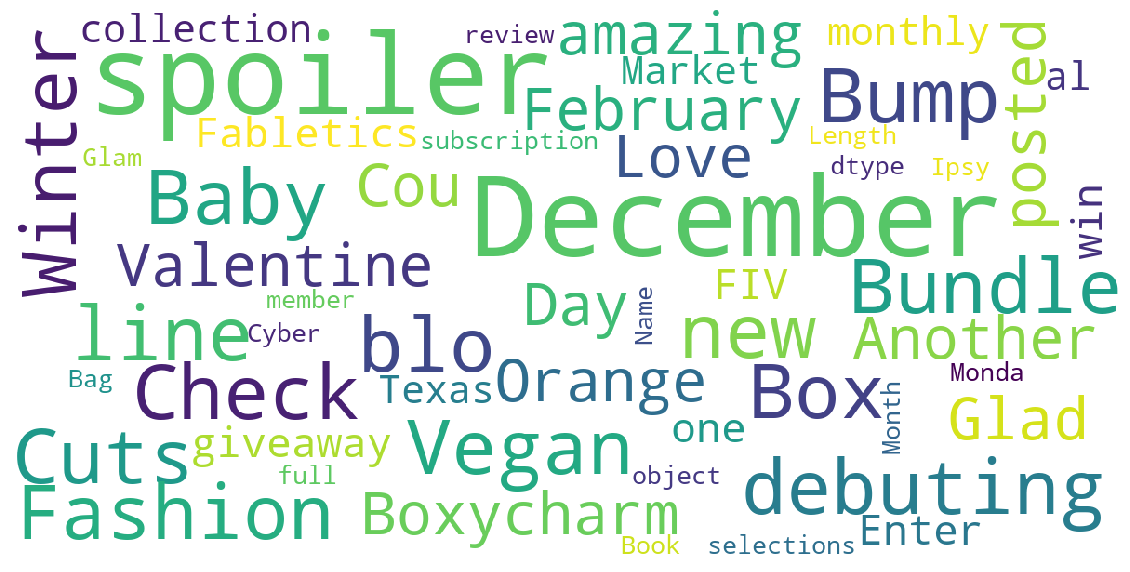

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

In [ ]:
# Can apply k-means clustering but the performance is not very good